In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0


In [2]:
path = '../../../project_data/data/fer_data.csv'
df = pd.read_csv(path)

# creating a dataframe that only contains training data
train = df[df['usage']=='train'].copy()
# dropping the usage column
train.drop(['usage'], axis = 1, inplace = True)
train.reset_index(inplace = True, drop = True)

# creating a dataframe that only contains training data
test = df[df['usage']=='test'].copy()
# dropping the usage column
test.drop(['usage'], axis = 1, inplace = True)
test.reset_index(inplace = True, drop = True)

# shuffling the test set
test = test.sample(frac=1).reset_index(drop=True)

In [3]:
# defininng validation set's length as a half of the original test set
valid_len = int(len(test)/2)
# and test as the remaining haflf
test_len = int(len(test) - valid_len)
print(valid_len,test_len)

3948 3948


In [4]:
valid = test.iloc[:valid_len,:]
valid.reset_index(inplace = True, drop=True)

test = test.iloc[test_len:,:]
test.reset_index(inplace = True, drop=True)

test.shape, valid.shape

((3948, 2), (3948, 2))

In [5]:
test.emotion.value_counts(normalize=True)

3    0.227964
4    0.160081
6    0.151469
2    0.124367
0    0.121834
1    0.109169
5    0.105117
Name: emotion, dtype: float64

In [6]:
valid.emotion.value_counts(normalize=True)

3    0.221378
6    0.160841
4    0.155775
2    0.135005
0    0.120567
5    0.105370
1    0.101064
Name: emotion, dtype: float64

In [7]:
test.head()

,emotion,pixels
0,0,70 66 31 9 10 8 8 11 24 49 62 93 117 124 125 1...
1,6,113 100 99 91 95 132 167 184 177 181 184 169 1...
2,3,217 219 203 178 163 161 135 151 162 168 184 20...
3,4,161 163 144 150 167 157 169 184 182 180 192 19...
4,4,195 192 183 183 165 169 189 165 131 73 19 28 3...


In [8]:
valid.head()

,emotion,pixels
0,2,177 145 75 55 65 64 115 197 172 146 130 116 11...
1,4,12 11 10 33 37 52 63 60 69 60 60 64 62 50 37 3...
2,0,181 179 177 175 175 175 173 171 169 166 166 16...
3,4,250 250 248 250 248 249 249 250 251 146 49 45 ...
4,6,7 7 10 9 5 5 8 7 13 20 23 27 26 21 21 17 12 13...


In [9]:
def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column|
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into a (48,48,1)format
    return a numpy array
    '''

    reshaped_array = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

In [10]:
train['pixels'] = train['pixels'].apply(get_pixels_and_scale)
test['pixels'] = test['pixels'].apply(get_pixels_and_scale)
valid['pixels'] = valid['pixels'].apply(get_pixels_and_scale)

In [11]:
X_train = reshape_images(train)
y_train = train['emotion'].to_numpy()

X_test = reshape_images(test)
y_test = test['emotion'].to_numpy()

X_valid = reshape_images(valid)
y_valid = valid['emotion'].to_numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(31432, 48, 48, 1) (31432,)
(3948, 48, 48, 1) (3948,)
(3948, 48, 48, 1) (3948,)


In [12]:
def plot_model_accuracy(fitted_model):
    '''
    Function visualizing comparison of 
    training and validaton loss and accuracy
    
    '''
    
    fig , ax = plt.subplots(1,2)
    train_acc = fitted_model.history['accuracy']
    train_loss = fitted_model.history['loss']
    fig.set_size_inches(15,4)

    ax[0].plot(fitted_model.history['accuracy'])
    ax[0].plot(fitted_model.history['val_accuracy'])
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(fitted_model.history['loss'])
    ax[1].plot(fitted_model.history['val_loss'])
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='lower left')

    plt.show()

## Final Model

In [13]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../../project_data/mdl16_2_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

Metal device set to: Apple M1


2022-05-18 23:06:10.234934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 23:06:10.235021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-05-18 23:06:10.479779: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 23:06:10.904873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.0169 - accuracy: 0.2267

2022-05-18 23:06:22.414545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 13s 378ms/step - loss: 2.0169 - accuracy: 0.2267 - val_loss: 1.9596 - val_accuracy: 0.2214
Epoch 2/100
30/30 [==============================] - 12s 374ms/step - loss: 1.9168 - accuracy: 0.2291 - val_loss: 1.9024 - val_accuracy: 0.2214
Epoch 3/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8987 - accuracy: 0.2290 - val_loss: 1.8896 - val_accuracy: 0.2221
Epoch 4/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8940 - accuracy: 0.2310 - val_loss: 1.8907 - val_accuracy: 0.2247
Epoch 5/100
30/30 [==============================] - 11s 364ms/step - loss: 1.8884 - accuracy: 0.2317 - val_loss: 1.8806 - val_accuracy: 0.2277
Epoch 6/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8819 - accuracy: 0.2353 - val_loss: 1.8791 - val_accuracy: 0.2366
Epoch 7/100
30/30 [==============================] - 11s 356ms/step - loss: 1.8741 - accuracy: 0.2419 - val_loss: 1.8464 - val_accuracy: 0.2573
Epoc

30/30 [==============================] - 12s 394ms/step - loss: 1.4243 - accuracy: 0.4613 - val_loss: 1.2784 - val_accuracy: 0.5215
Epoch 58/100
30/30 [==============================] - 12s 395ms/step - loss: 1.4166 - accuracy: 0.4678 - val_loss: 1.2690 - val_accuracy: 0.5350
Epoch 59/100
30/30 [==============================] - 12s 385ms/step - loss: 1.4111 - accuracy: 0.4733 - val_loss: 1.2278 - val_accuracy: 0.5461
Epoch 60/100
30/30 [==============================] - 12s 384ms/step - loss: 1.4180 - accuracy: 0.4678 - val_loss: 1.2206 - val_accuracy: 0.5484
Epoch 61/100
30/30 [==============================] - 12s 374ms/step - loss: 1.3965 - accuracy: 0.4749 - val_loss: 1.2487 - val_accuracy: 0.5375
Epoch 62/100
30/30 [==============================] - 12s 373ms/step - loss: 1.4103 - accuracy: 0.4693 - val_loss: 1.2304 - val_accuracy: 0.5486
Epoch 63/100
30/30 [==============================] - 12s 371ms/step - loss: 1.4023 - accuracy: 0.4745 - val_loss: 1.2694 - val_accuracy: 0.525

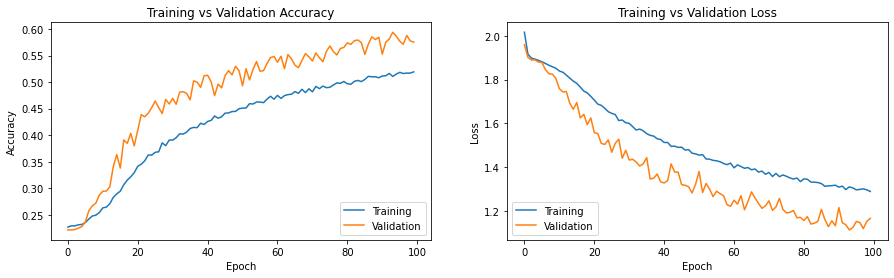

Evaluate on test data
 1/31 [..............................] - ETA: 6s - loss: 1.0464 - accuracy: 0.5938

2022-05-18 23:26:46.602590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step - loss: 1.1488 - accuracy: 0.5737
test_loss, test_acc:  1.1488 57.3708


In [14]:
mdl16_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl16_2 = mdl16_2.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 100,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_2)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_2.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

# 2000 epochs - stopped by Early Stopping

In [15]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../../project_data/mdl16_2_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

Epoch 1/2000


2022-05-18 23:35:28.485124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.0175 - accuracy: 0.2263

2022-05-18 23:35:40.098948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 13s 385ms/step - loss: 2.0175 - accuracy: 0.2263 - val_loss: 1.9606 - val_accuracy: 0.2214
Epoch 2/2000
30/30 [==============================] - 12s 379ms/step - loss: 1.9162 - accuracy: 0.2290 - val_loss: 1.9023 - val_accuracy: 0.2249
Epoch 3/2000
30/30 [==============================] - 12s 378ms/step - loss: 1.9009 - accuracy: 0.2286 - val_loss: 1.9109 - val_accuracy: 0.2216
Epoch 4/2000
30/30 [==============================] - 12s 395ms/step - loss: 1.8949 - accuracy: 0.2303 - val_loss: 1.8855 - val_accuracy: 0.2244
Epoch 5/2000
30/30 [==============================] - 12s 382ms/step - loss: 1.8900 - accuracy: 0.2321 - val_loss: 1.8832 - val_accuracy: 0.2378
Epoch 6/2000
30/30 [==============================] - 12s 373ms/step - loss: 1.8845 - accuracy: 0.2340 - val_loss: 1.8661 - val_accuracy: 0.2538
Epoch 7/2000
30/30 [==============================] - 11s 362ms/step - loss: 1.8765 - accuracy: 0.2393 - val_loss: 1.8632 - val_accuracy: 0.241

30/30 [==============================] - 11s 360ms/step - loss: 1.4234 - accuracy: 0.4646 - val_loss: 1.3544 - val_accuracy: 0.4939
Epoch 58/2000
30/30 [==============================] - 11s 361ms/step - loss: 1.4258 - accuracy: 0.4621 - val_loss: 1.3180 - val_accuracy: 0.5096
Epoch 59/2000
30/30 [==============================] - 11s 360ms/step - loss: 1.4166 - accuracy: 0.4695 - val_loss: 1.2653 - val_accuracy: 0.5299
Epoch 60/2000
30/30 [==============================] - 11s 357ms/step - loss: 1.4149 - accuracy: 0.4710 - val_loss: 1.2621 - val_accuracy: 0.5256
Epoch 61/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.4074 - accuracy: 0.4707 - val_loss: 1.2498 - val_accuracy: 0.5337
Epoch 62/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.4102 - accuracy: 0.4693 - val_loss: 1.2243 - val_accuracy: 0.5504
Epoch 63/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.4066 - accuracy: 0.4714 - val_loss: 1.2552 - val_accuracy:

30/30 [==============================] - 11s 358ms/step - loss: 1.2683 - accuracy: 0.5283 - val_loss: 1.0831 - val_accuracy: 0.6031
Epoch 114/2000
30/30 [==============================] - 11s 356ms/step - loss: 1.2567 - accuracy: 0.5320 - val_loss: 1.0843 - val_accuracy: 0.6059
Epoch 115/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.2666 - accuracy: 0.5286 - val_loss: 1.0967 - val_accuracy: 0.5985
Epoch 116/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.2657 - accuracy: 0.5290 - val_loss: 1.0930 - val_accuracy: 0.5945
Epoch 117/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.2545 - accuracy: 0.5347 - val_loss: 1.1218 - val_accuracy: 0.5846
Epoch 118/2000
30/30 [==============================] - 11s 357ms/step - loss: 1.2523 - accuracy: 0.5343 - val_loss: 1.0906 - val_accuracy: 0.5945
Epoch 119/2000
30/30 [==============================] - 11s 361ms/step - loss: 1.2531 - accuracy: 0.5327 - val_loss: 1.0949 - val_acc

Epoch 169/2000
30/30 [==============================] - 11s 360ms/step - loss: 1.1812 - accuracy: 0.5632 - val_loss: 1.0337 - val_accuracy: 0.6228
Epoch 170/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.1837 - accuracy: 0.5606 - val_loss: 1.0376 - val_accuracy: 0.6221
Epoch 171/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.1881 - accuracy: 0.5581 - val_loss: 1.0525 - val_accuracy: 0.6165
Epoch 172/2000
30/30 [==============================] - 921s 31s/step - loss: 1.1766 - accuracy: 0.5621 - val_loss: 1.0779 - val_accuracy: 0.6046
Epoch 173/2000
30/30 [==============================] - 12s 372ms/step - loss: 1.1820 - accuracy: 0.5582 - val_loss: 1.0396 - val_accuracy: 0.6173
Epoch 174/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.1788 - accuracy: 0.5633 - val_loss: 1.0263 - val_accuracy: 0.6317
Epoch 175/2000
30/30 [==============================] - 11s 355ms/step - loss: 1.1796 - accuracy: 0.5626 - val_loss: 1.

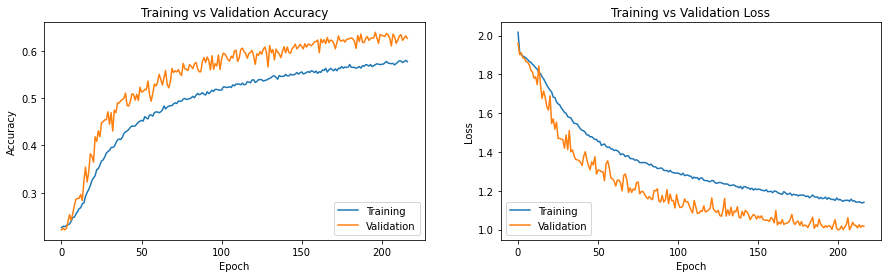

Evaluate on test data
 1/31 [..............................] - ETA: 8s - loss: 0.8801 - accuracy: 0.6719

2022-05-19 02:45:28.716734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step - loss: 1.0078 - accuracy: 0.6315
test_loss, test_acc:  1.0078 63.1459


In [16]:
mdl16_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_3.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl16_3 = mdl16_3.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 2000,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_3)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_3.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

In [17]:
mdl16_3.save('../../../project_data/mdl16_3.h5')

# 16.4 - continuing without early stopping

In [18]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint_path = "../../../project_data/train_ckpt/cp.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

#define callbacks
callbacks = [checkpoint]

In [20]:
# load the model and run a summary
mdl16_4 = tf.keras.models.load_model('../../../project_data/mdl16_3.h5')
mdl16_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
history_mdl16_4 = mdl16_4.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 1000,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_4)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_4.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

Epoch 1/1000


2022-05-19 07:42:16.167361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 1.1480 - accuracy: 0.5747

2022-05-19 07:42:28.892871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.62893, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 14s 402ms/step - loss: 1.1480 - accuracy: 0.5747 - val_loss: 0.9995 - val_accuracy: 0.6289
Epoch 2/1000
31/30 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.5747
Epoch 2: val_accuracy improved from 0.62893 to 0.64438, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 11s 358ms/step - loss: 1.1522 - accuracy: 0.5747 - val_loss: 0.9891 - val_accuracy: 0.6444
Epoch 3/1000
31/30 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.5767
Epoch 3: val_accuracy did not improve from 0.64438
30/30 [==============================] - 11s 355ms/step - loss: 1.1476 - accuracy: 0.5767 - val_loss: 1.0152 - val_accuracy: 0.6292
Epoch 4/1000
31/30 [==============================] - ETA: 0s - loss: 1.1491 - accuracy: 0.5735
Epoch 4: val_accuracy did not improve fro

30/30 [==============================] - 11s 364ms/step - loss: 1.1369 - accuracy: 0.5802 - val_loss: 0.9775 - val_accuracy: 0.6464
Epoch 30/1000
31/30 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.5843
Epoch 30: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 382ms/step - loss: 1.1235 - accuracy: 0.5843 - val_loss: 1.0027 - val_accuracy: 0.6332
Epoch 31/1000
31/30 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.5775
Epoch 31: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 372ms/step - loss: 1.1372 - accuracy: 0.5775 - val_loss: 0.9795 - val_accuracy: 0.6348
Epoch 32/1000
31/30 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.5847
Epoch 32: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 374ms/step - loss: 1.1257 - accuracy: 0.5847 - val_loss: 1.0167 - val_accuracy: 0.6264
Epoch 33/1000
31/30 [====

31/30 [==============================] - ETA: 0s - loss: 1.1103 - accuracy: 0.5879
Epoch 58: val_accuracy did not improve from 0.65426
30/30 [==============================] - 12s 382ms/step - loss: 1.1103 - accuracy: 0.5879 - val_loss: 0.9690 - val_accuracy: 0.6456
Epoch 59/1000
31/30 [==============================] - ETA: 0s - loss: 1.1150 - accuracy: 0.5890
Epoch 59: val_accuracy did not improve from 0.65426
30/30 [==============================] - 13s 413ms/step - loss: 1.1150 - accuracy: 0.5890 - val_loss: 0.9758 - val_accuracy: 0.6408
Epoch 60/1000
31/30 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.5899
Epoch 60: val_accuracy did not improve from 0.65426
30/30 [==============================] - 12s 395ms/step - loss: 1.1064 - accuracy: 0.5899 - val_loss: 0.9753 - val_accuracy: 0.6418
Epoch 61/1000
31/30 [==============================] - ETA: 0s - loss: 1.1099 - accuracy: 0.5904
Epoch 61: val_accuracy did not improve from 0.65426
30/30 [===============

31/30 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5948
Epoch 87: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 491ms/step - loss: 1.0962 - accuracy: 0.5948 - val_loss: 0.9737 - val_accuracy: 0.6456
Epoch 88/1000
31/30 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.5927
Epoch 88: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 472ms/step - loss: 1.0955 - accuracy: 0.5927 - val_loss: 0.9781 - val_accuracy: 0.6472
Epoch 89/1000
31/30 [==============================] - ETA: 0s - loss: 1.0914 - accuracy: 0.5984
Epoch 89: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 481ms/step - loss: 1.0914 - accuracy: 0.5984 - val_loss: 0.9525 - val_accuracy: 0.6510
Epoch 90/1000
31/30 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.5939
Epoch 90: val_accuracy did not improve from 0.65426
30/30 [===============

Epoch 116/1000
31/30 [==============================] - ETA: 0s - loss: 1.0776 - accuracy: 0.6016
Epoch 116: val_accuracy did not improve from 0.66109
30/30 [==============================] - 16s 525ms/step - loss: 1.0776 - accuracy: 0.6016 - val_loss: 0.9491 - val_accuracy: 0.6588
Epoch 117/1000
31/30 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.6009
Epoch 117: val_accuracy did not improve from 0.66109
30/30 [==============================] - 16s 522ms/step - loss: 1.0777 - accuracy: 0.6009 - val_loss: 0.9459 - val_accuracy: 0.6512
Epoch 118/1000
31/30 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.5991
Epoch 118: val_accuracy did not improve from 0.66109
30/30 [==============================] - 17s 541ms/step - loss: 1.0874 - accuracy: 0.5991 - val_loss: 0.9455 - val_accuracy: 0.6606
Epoch 119/1000
31/30 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.5999
Epoch 119: val_accuracy did not improve from 0.66109


30/30 [==============================] - 17s 553ms/step - loss: 1.0746 - accuracy: 0.6050 - val_loss: 0.9244 - val_accuracy: 0.6591
Epoch 145/1000
31/30 [==============================] - ETA: 0s - loss: 1.0743 - accuracy: 0.6046
Epoch 145: val_accuracy did not improve from 0.66337
30/30 [==============================] - 17s 545ms/step - loss: 1.0743 - accuracy: 0.6046 - val_loss: 0.9630 - val_accuracy: 0.6464
Epoch 146/1000
31/30 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.6033
Epoch 146: val_accuracy did not improve from 0.66337
30/30 [==============================] - 17s 563ms/step - loss: 1.0725 - accuracy: 0.6033 - val_loss: 0.9400 - val_accuracy: 0.6631
Epoch 147/1000
31/30 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.6073
Epoch 147: val_accuracy did not improve from 0.66337
30/30 [==============================] - 18s 565ms/step - loss: 1.0650 - accuracy: 0.6073 - val_loss: 0.9541 - val_accuracy: 0.6502
Epoch 148/1000
31/3